In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

os.chdir("/content/drive/MyDrive/smart-cart")

#Converting Data to YOLO format


## Resize images + Annotations

In [ ]:
!mkdir -p yolo/datasets/images/train yolo/datasets/images/val  yolo/datasets/labels/train yolo/datasets/labels/val && touch  yolo/datasets/data.yaml

In [ ]:
!ls ./yolo/datasets/

data.yaml  train  val


In [ ]:
import cv2
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
def resize_image(image, r_aspect_ratio=3):

  new_width = image.shape[1]// r_aspect_ratio
  new_height = image.shape[0]// r_aspect_ratio

  resized_image = cv2.resize(image, (new_width,new_height), interpolation=cv2.INTER_LINEAR)

  return resized_image

def resize_polygon(polygon,r_aspect_ratio=3):

  resized_polygon = [(x//r_aspect_ratio, y//r_aspect_ratio) for x, y in polygon]

  return resized_polygon

def read_annotation(ann_path):

  with open(ann_path, "r") as f:
    annotation = json.load(f)

  return annotation

def read_image(image_path):

  image = cv2.imread(image_path)
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

  return image

# metadata_path = "./dataset/meta.json"

# with open(metadata_path, "r") as f:
#   metadata = json.load(f)


def plot_image_instance_mask(image, polygon):

  fig, ax = plt.subplots(1,1)

  polygon = Polygon([*polygon], alpha=0.9)
  ax.add_patch(polygon)

  ax.imshow(image, alpha=0.8)
  plt.show()

## Example Resizing a single image and its annotations

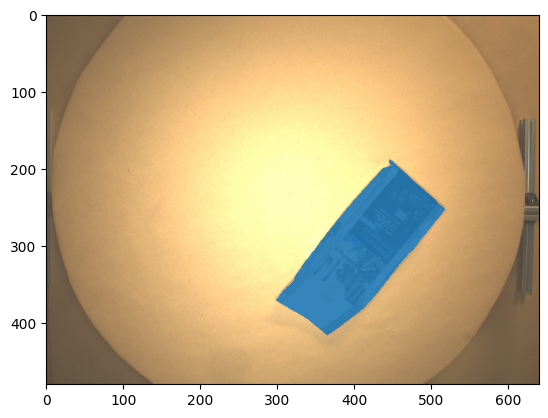

In [ ]:
image_path = "./dataset/training/img/D2S_001218_D2S_training.jpg"
ann_path = "./dataset/training/ann/D2S_001218_D2S_training.jpg.json"

image = read_image(image_path)
ann = read_annotation(ann_path)

resized_image = resize_image(image, r_aspect_ratio=3)
resized_polygon = resize_polygon(ann["objects"][0]["points"]["exterior"], r_aspect_ratio=3)

plot_image_instance_mask(resized_image, resized_polygon)

Yolo is trained on images of size 640x640. So it's better to fine-tune it on images with same size. Since the height in the current dataset, after resizing, is less than 640. ultralytics pads, automatically, that axe to form a square image of size 640x640

## Resizing the whole dataset + Save the results in YOLO format

In [ ]:
import numpy as np

def save_image(image:  np.ndarray, image_path: str) -> bool:

    """Writes an image in RGB format to the given path.

    Returns:
        bool: True if the image was written successfully else False.
    """

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return cv2.imwrite(image_path, image)

def create_data_yaml(root_dir, classes, train_path, val_path , dataset_path):

  """
    path: ../datasets/coco8-seg # dataset root dir
    train: images/train # train images (relative to 'path')
    val: images/val # val images (relative to 'path')

    names:
        0: person
        1: bicycle
        2: car
        # ...
  """

  with open(os.path.join(dataset_path, "data.yaml"), "w", encoding="UTF-8") as f:
        f.write(
            f'path: {root_dir} \ntrain: {train_path}\nval: {val_path}\n\nnames:'
        )
        f.writelines(["\n    "+str(id)+": "+name for (id,name) in classes.items()])


def convert_annotation_to_yolo(src, dest, origId_yoloId_dict, resize=True, r_aspect_ratio=3):

  for root, subdirs, filenames in os.walk(src):

    for filename in filenames:
      abs_filename = os.path.join(root, filename)
      # annotation: {description, tags, size:{height, width},
      #        objects: [{classId,.., points: {exterior: [...], interior: []}}]}
      ann = read_annotation(abs_filename)
      h, w = ann["size"]["height"], ann["size"]["width"]


      polygones = list(map(lambda instance: instance["points"]["exterior"], ann["objects"])) # [[[x,y],[x,y],[x,y]],]
      classes = list(map(lambda instance: instance["classId"], ann["objects"]))


      if resize:
        h, w = h//r_aspect_ratio, w//r_aspect_ratio
        polygones = [resize_polygon(polygon, r_aspect_ratio=r_aspect_ratio) for polygon in polygones]

      # normalize polygones [(x1,y1),(x2,y2),...(xn,yn)]
      polygones = [np.round(np.array(polygon)/np.array([w,h]),decimals=4) for polygon in polygones]

      # validate the normalization
      for polygon in polygones:
        assert np.all(polygon < 1), f'Polygones have not been normalized correctly. Some values > 1'


      # convert to yolo format: class_id x1 y1 x2 y2 x3 y3 .... xn yn
      lines = []


      for class_id, polygon in zip(classes,polygones):

        yolo_id = origId_yoloId_dict[class_id]
        polygon = polygon.astype(str)

        line = str(yolo_id)+" "+" ".join([" ".join(point) for point in polygon])+"\n"
        lines.append(line)

      # print(f'Lines: {lines}')

      # Save the annotation to .txt file
      # filenames are the same as the images except for the additional .json
      dest_filename = os.path.join(dest,filename.split(".")[0]+".txt")
      with open(dest_filename, "w") as f:
        f.writelines(lines)

def resize_images_folder(src, dest):

  for root, subdirs, filenames in os.walk(src):

    for filename in filenames:
      try:
        abs_filename = os.path.join(root, filename)
        image = read_image(abs_filename)

        resized_image = resize_image(image,r_aspect_ratio=3)
        saved = save_image(resized_image, os.path.join(dest, filename))
        if not saved:
          print(f"Failed to save image: {abs_filename}")
        else:
          print(f'Saved filename: {os.path.join(dest, filename)}')
      except Exception as e:
        print(f'Error : Failed to resize and save image: {filename}:\n {e}')



In [ ]:
!ls ./yolo/datasets/images/train

### Resize Training Set Images

In [ ]:
src1 = "./dataset/training/img"
src2 = "./dataset/augmented/img"
dest = "./yolo/datasets/images/train"
resize_images_folder(src1, dest)
resize_images_folder(src2, dest)

Saved filename: ./yolo/datasets/images/train/D2S_011000_D2S_training_rot0.jpg
Saved filename: ./yolo/datasets/images/train/D2S_018700_D2S_training_light0.jpg
Saved filename: ./yolo/datasets/images/train/D2S_010606_D2S_training_light0.jpg
Saved filename: ./yolo/datasets/images/train/D2S_004003_D2S_training_light0.jpg
Saved filename: ./yolo/datasets/images/train/D2S_017000_D2S_training_rot0_light0.jpg
Saved filename: ./yolo/datasets/images/train/D2S_005400_D2S_training_rot0_light0.jpg
Saved filename: ./yolo/datasets/images/train/D2S_005408_D2S_training_light0.jpg
Saved filename: ./yolo/datasets/images/train/D2S_014008_D2S_training_light0.jpg
Saved filename: ./yolo/datasets/images/train/D2S_013801_D2S_training_light0.jpg
Saved filename: ./yolo/datasets/images/train/D2S_009906_D2S_training_light0.jpg
Saved filename: ./yolo/datasets/images/train/D2S_003126_D2S_training.jpg
Saved filename: ./yolo/datasets/images/train/D2S_001218_D2S_training.jpg
Saved filename: ./yolo/datasets/images/train/D

### Resize Validation Set Images

In [ ]:
src = "./dataset/validation/img"
dest = "./yolo/datasets/images/val"
resize_images_folder(src, dest)

Saved filename: ./yolo/datasets/images/val/D2S_055220_D2S_validation_random_background_wo_clutter.jpg
Saved filename: ./yolo/datasets/images/val/D2S_032712_D2S_validation_wo_occlusion.jpg
Saved filename: ./yolo/datasets/images/val/D2S_023329_D2S_validation_wo_occlusion.jpg
Saved filename: ./yolo/datasets/images/val/D2S_024206_D2S_validation_wo_occlusion.jpg
Saved filename: ./yolo/datasets/images/val/D2S_056911_D2S_validation_random_background_wo_clutter.jpg
Saved filename: ./yolo/datasets/images/val/D2S_025210_D2S_validation_wo_occlusion.jpg
Saved filename: ./yolo/datasets/images/val/D2S_023001_D2S_validation_wo_occlusion.jpg
Saved filename: ./yolo/datasets/images/val/D2S_023326_D2S_validation_wo_occlusion.jpg
Saved filename: ./yolo/datasets/images/val/D2S_043728_D2S_validation_wo_occlusion.jpg
Saved filename: ./yolo/datasets/images/val/D2S_044020_D2S_validation_wo_occlusion.jpg
Saved filename: ./yolo/datasets/images/val/D2S_065228_D2S_validation_random_background_wo_clutter.jpg
Saved 

In [ ]:
metadata_path = "./dataset/meta.json"

with open(metadata_path, "r") as f:
  metadata = json.load(f)
orig_class_ids = list(map(lambda meta: meta["id"], metadata["classes"]))
classId_names = {class_meta["id"]: class_meta["title"] for class_meta in metadata["classes"]}
orig_class_ids.sort()

In [ ]:
origId_yoloId_dict = {orig_id: idx for (idx, orig_id) in enumerate(orig_class_ids)}
origId_yoloId_dict[orig_class_ids[0]]

0

### Resize Training Set annotations

In [ ]:
src1 = "./dataset/training/ann"
src2 = "./dataset/augmented/ann"
dest = "./yolo/datasets/labels/train"
convert_annotation_to_yolo(src1,dest,origId_yoloId_dict)

In [ ]:
dest = "./yolo/datasets/labels/train"
convert_annotation_to_yolo(src2,dest,origId_yoloId_dict)

### Resize Validation Set annotations

In [ ]:
src = "./dataset/validation/ann"
dest = "./yolo/datasets/labels/val"
convert_annotation_to_yolo(src,dest,origId_yoloId_dict)

## Data validation

In [ ]:
# Verify that number of image files matches the number of annotation files
assert len(os.listdir("./yolo/datasets/labels/train")) == len( os.listdir("./yolo/datasets/images/train"))
assert len(os.listdir("./yolo/datasets/labels/val")) == len( os.listdir("./yolo/datasets/images/val"))

### Plotting some samples from Training + Validation sets

In [ ]:
from random import choice

In [ ]:
tr_filenames = os.listdir("./yolo/datasets/images/train")
tr_sample = [choice(tr_filenames) for _ in range(10)]

val_filenames = os.listdir("./yolo/datasets/images/val")
val_sample = [choice(val_filenames) for _ in range(10)]

In [ ]:
tr_imag_sample = [os.path.join("./yolo/datasets/images/train", filename) for filename in tr_sample]
tr_label_sample = [os.path.join("./yolo/datasets/labels/train", filename.split(".")[0]+".txt") for filename in tr_sample]

val_imag_sample = [os.path.join("./yolo/datasets/images/val", filename) for filename in val_sample]
val_label_sample = [os.path.join("./yolo/datasets/labels/val", filename.split(".")[0]+".txt") for filename in val_sample]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def read_yolo_annotation(ann_path):

  with open(ann_path, 'r') as f:
    lines = f.readlines()

  instances = []

  for idx, line in enumerate(lines):

    class_id, *polygon = line.split(' ')
    instances.append({"classId": class_id,
                      "polygon": np.array(polygon).astype(float).reshape(-1,2)}) # save as numpy to facilitate restoring the coordinates later

  return instances


def plot_image_labels(image_paths, label_paths, subplot=(2,5), title="Training Resized samples"):

  fig, axes = plt.subplots(*subplot, figsize=(16,8))
  fig.suptitle(title)
  i,j = 0,0
  for idx,(image_p, ann_p) in enumerate(zip(image_paths, label_paths)):

    image = read_image(image_p)
    instances = read_yolo_annotation(ann_p)
    h,w  = image.shape[:2]
    i,j = idx //5 ,idx % 5
    axes[i,j].imshow(image, alpha=0.8)
    for instance in instances:


      # print(h_color)
      points = (instance["polygon"]*np.array([w,h])).astype(int)
      # print(f"points: {points}")
      polygon = Polygon([*points], alpha=0.9)

      axes[i,j].add_patch(polygon)

  plt.show()


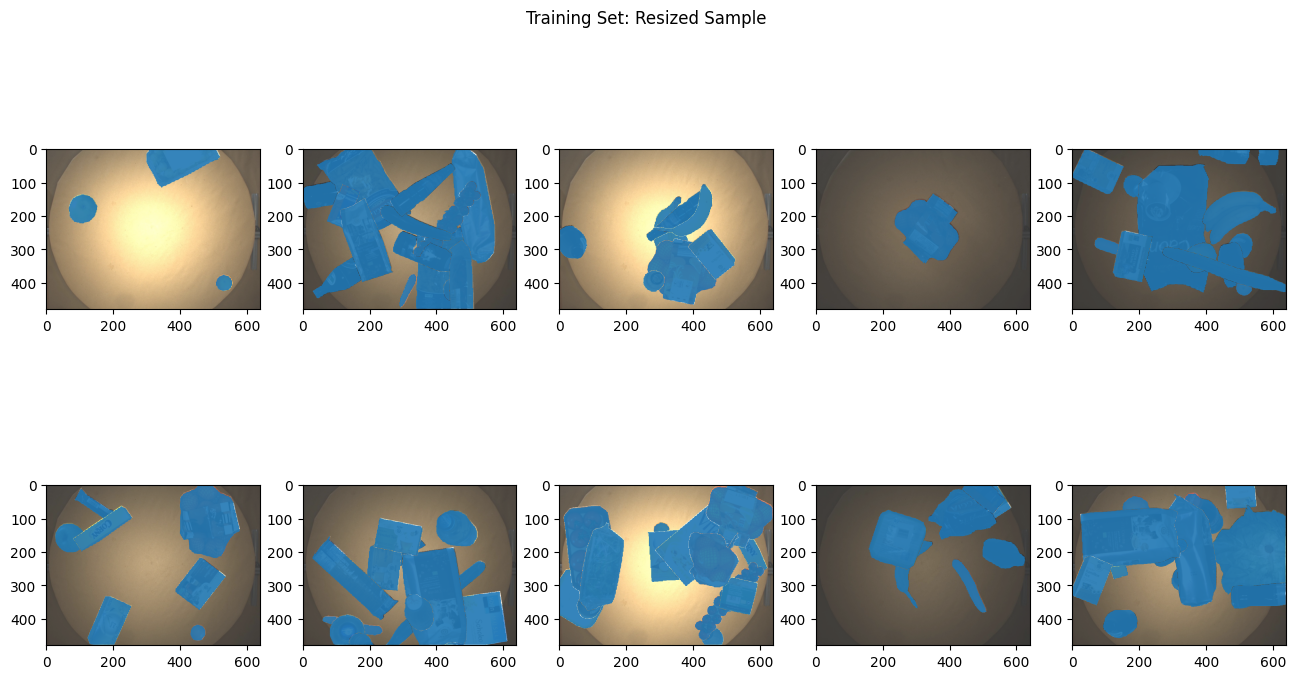

In [ ]:
plot_image_labels(tr_imag_sample, tr_label_sample, subplot=(2,5),title="Training Set: Resized Sample")

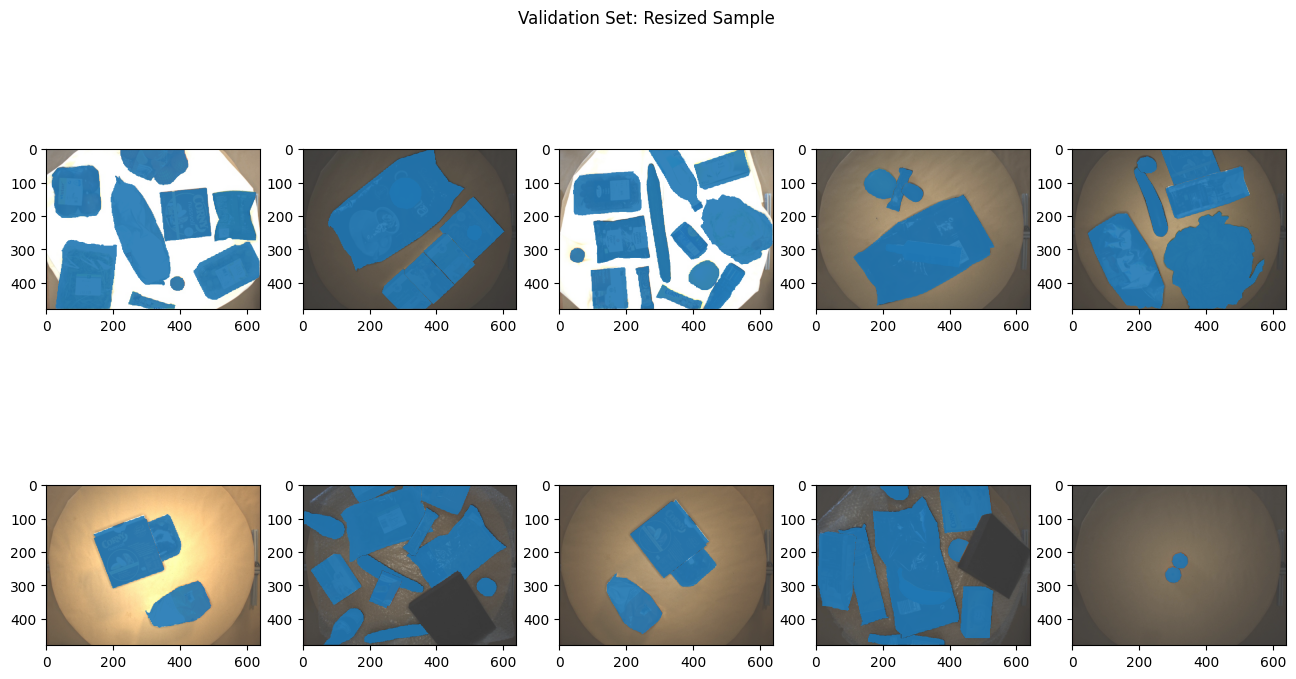

In [ ]:
plot_image_labels(val_imag_sample, val_label_sample, subplot=(2,5), title="Validation Set: Resized Sample")

## Create Data Yaml config file for YOLO

In [ ]:
root_dir = "../datasets"
classes = {}

for orig_id, name in classId_names.items():
  classes[origId_yoloId_dict[orig_id]] = name

train_path = "images/train" # relative to root_dir
val_path = "images/val" # relative to root_dir
dataset_path = "./yolo/datasets"
create_data_yaml(root_dir, classes, train_path, val_path , dataset_path)
